In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [2]:
inspire_path = Path("/home/server/Projects/data/INSPIRE/physionet.org/files/inspire/1.3")
ops_path = inspire_path / "operations.csv"
labs_path = inspire_path / "labs.csv"
vitals_path = inspire_path / "vitals.csv"
ward_vitals_path = inspire_path / "ward_vitals.csv"
combined_path = inspire_path / "combined_data.csv"
combined_cleaned_path = inspire_path / "combined_cleaned_data.csv"
pca_path = inspire_path / "pca_data.csv"

In [3]:
# Set variables
OUTCOME_VAR = 'inhosp_death_30day'
INPUT_VARS = ['age', 'sex', 'emop', 'bmi', 'andur', 
              'preop_hb', 'preop_platelet', 'preop_wbc', 'preop_aptt', 'preop_ptinr', 'preop_glucose',
              'preop_bun', 'preop_albumin', 'preop_ast', 'preop_alt', 'preop_creatinine', 'preop_sodium', 'preop_potassium']

# Load operations
df = pd.read_csv(ops_path.as_posix())

# find the first operation for each patient
df.sort_values('orin_time', inplace=True)
df = df.loc[df[['op_id','subject_id']].groupby('subject_id')['op_id'].idxmin()]

df[OUTCOME_VAR] = (df['inhosp_death_time'] < df['orout_time'] + 30 * 24 * 60)
df = df[(df['asa'] < 6)]
df.loc[:, 'andur'] = df['anend_time'] - df['anstart_time']

valid_mask = df['height'] > 10
df['bmi'] = np.nan
df.loc[valid_mask, 'bmi'] = df.loc[valid_mask, 'weight'] / (df.loc[valid_mask, 'height'] / 100) ** 2

In [4]:
# Load labs
df_lab = pd.read_csv(labs_path.as_posix())
necessary_vars_labs = df_lab['item_name'].unique().tolist()#['hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium']
print(necessary_vars_labs)
for item_name in necessary_vars_labs:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_lab.loc[df_lab['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'preop_{item_name}'}, inplace=True)

df['sex'] = df['sex'] == 'M'

['total_protein', 'sodium', 'potassium', 'platelet', 'glucose', 'wbc', 'alt', 'chloride', 'lymphocyte', 'phosphorus', 'albumin', 'fibrinogen', 'creatinine', 'ptinr', 'total_bilirubin', 'alp', 'aptt', 'calcium', 'bun', 'ast', 'crp', 'hb', 'hct', 'seg', 'ica', 'ph', 'paco2', 'pao2', 'hco3', 'sao2', 'lacate', 'ckmb', 'troponin_i', 'ck', 'hba1c', 'be', 'troponin_t', 'd_dimer']


In [18]:
# Load vitals
df_vitals = pd.read_csv(vitals_path.as_posix())
necessary_vars_vitals = df_vitals['item_name'].unique().tolist()#['hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium']
print(necessary_vars_vitals)
for item_name in necessary_vars_vitals:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_vitals.loc[df_vitals['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'early_op_{item_name}'}, inplace=True)


['minvol', 'vt', 'rr', 'pip', 'nibp_sbp', 'nibp_dbp', 'nibp_mbp', 'o2', 'hs', 'hr', 'spo2', 'air', 'etco2', 'bt', 'uo', 'peep', 'fio2', 'bis', 'ebl', 'ppfi', 'rfti', 'hes', 'ns', 'etsevo', 'etgas', 'art_sbp', 'art_dbp', 'art_mbp', 'cvp', 'pap_sbp', 'pap_dbp', 'pap_mbp', 'ntgi', 'nepi', 'ci', 'rbc', 'dobui', 'ffp', 'pc', 'cryo', 'n2o', 'psa', 'ppf', 'etdes', 'hns', 'alb20', 'mlni', 'pepi', 'dopai', 'mdz', 'ftn', 'd5w', 'alb5', 'epii', 'cbro2', 'd10w', 'ds', 'pplat', 'pmean', 'd50w', 'sft', 'phe', 'eph', 'cpat', 'vaso', 'epi', 'pheresis', 'etiso', 'aft', 'svi', 'stii', 'stv5', 'stiii', 'sti']


KeyboardInterrupt: 

In [ ]:
# Load ward vitals
df_ward_vitals = pd.read_csv(ward_vitals_path.as_posix())
necessary_vars_ward_vitals = df_ward_vitals['item_name'].unique().tolist()#['hb', 'platelet', 'aptt', 'wbc', 'ptinr', 'glucose', 'bun', 'albumin', 'ast', 'alt', 'creatinine', 'sodium', 'potassium']
print(necessary_vars_vitals)
for item_name in necessary_vars_ward_vitals:
    df = pd.merge_asof(df.sort_values('orin_time'), 
                    df_ward_vitals.loc[df_ward_vitals['item_name'] == item_name].sort_values('chart_time'), 
                    left_on='orin_time', right_on='chart_time', by='subject_id', 
                    tolerance=6* 30 * 24 * 60, suffixes=('', '_'))
    df.drop(columns=['chart_time', 'item_name'], inplace=True)
    df.rename(columns={'value':f'pre_op_{item_name}'}, inplace=True)

In [ ]:
# Write the DataFrame to a CSV file

df.to_csv(combined_path.as_posix(), index=False)

In [ ]:
# pd.set_option('display.max_columns', None)  # Display all columns
# pd.set_option('display.width', None)   
# print(df.head(1))

# Find the intersection of subject_id values in both DataFrames
subject_id_intersection = list(set(df['subject_id']).intersection(set(df_vitals['subject_id'])))

# Print the list of intersecting subject_id values
print(subject_id_intersection)

print(len(subject_id_intersection))

In [ ]:
# Filter the DataFrame for the specific subject_id
subject_row = df[df['subject_id'] == 120324114]

# Print the row
print(subject_row)

In [ ]:
df

In [19]:
df_combined = pd.read_csv(combined_path.as_posix())
df_combined

,op_id,subject_id,hadm_id,case_id,opdate,age,sex,weight,height,race,...,pre_op_nibp_mbp,pre_op_crrt,pre_op_ecmo,pre_op_uo,pre_op_vent,pre_op_gcs_e,pre_op_gcs_m,pre_op_gcs_v,pre_op_fio2,pre_op_iabp
0,403543518,164935053,251633071,NaN,0,45,True,65.0,180.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,429493668,196269490,269094492,NaN,0,55,False,60.0,160.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,490288058,143981214,268056914,1211.0,0,75,True,NaN,NaN,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,453052475,140696052,251635295,NaN,0,75,False,50.0,155.0,Asian,...,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,474826299,122791000,258548446,NaN,0,50,False,50.0,160.0,Asian,...,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,NaN,5031360,50,True,75.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97285,409353759,157622470,278769283,NaN,5064480,65,True,60.0,160.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97286,417368839,196070660,228888251,NaN,5065920,70,True,65.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97287,434627934,106196053,264484804,NaN,5078880,65,True,70.0,165.0,Asian,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Calculate the percentage of NaN values in each column
nan_percentage = df_combined.isna().mean() * 100

# Create a DataFrame from the NaN percentage series for better display
nan_percentage_df = nan_percentage.to_frame(name='NaN Percentage').reset_index()
nan_percentage_df.columns = ['Column', 'NaN Percentage']

pd.set_option('display.max_columns', 10)  # Display all columns
pd.set_option('display.width', None) 
pd.set_option('display.max_rows', 10)

nan_percentage_df

,Column,NaN Percentage
0,op_id,0.000000
1,subject_id,0.000000
2,hadm_id,0.000000
3,case_id,83.335218
4,opdate,0.000000
...,...,...
229,pre_op_gcs_e,98.629855
230,pre_op_gcs_m,98.629855
231,pre_op_gcs_v,98.788147
232,pre_op_fio2,98.925881


In [21]:
columns_to_drop = nan_percentage_df[nan_percentage_df['NaN Percentage'] > 70]['Column']
# Drop these columns from df_combined
df_combined = df_combined.drop(columns=columns_to_drop)

# Display the updated DataFrame
df_combined


,op_id,subject_id,hadm_id,opdate,age,...,pre_op_nibp_sbp,pre_op_hr,pre_op_nibp_dbp,pre_op_bt,pre_op_rr
0,403543518,164935053,251633071,0,45,...,113.0,96.0,67.0,37.3,16.0
1,429493668,196269490,269094492,0,55,...,150.0,68.0,94.0,36.3,19.0
2,490288058,143981214,268056914,0,75,...,136.0,88.0,62.0,36.0,17.0
3,453052475,140696052,251635295,0,75,...,136.0,56.0,60.0,36.4,18.0
4,474826299,122791000,258548446,0,50,...,144.0,96.0,64.0,36.3,18.0
...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,5031360,50,...,108.0,66.0,67.0,36.3,17.0
97285,409353759,157622470,278769283,5064480,65,...,110.0,64.0,72.0,36.4,17.0
97286,417368839,196070660,228888251,5065920,70,...,150.0,56.0,82.0,36.0,19.0
97287,434627934,106196053,264484804,5078880,65,...,169.0,120.0,100.0,36.3,19.0


In [ ]:
df_combined

In [12]:
# Write the DataFrame to a CSV file

df_combined.to_csv(combined_cleaned_path.as_posix(), index=False)

In [22]:
df_combined_cleaned = pd.read_csv(combined_cleaned_path.as_posix())

In [23]:
df_combined_cleaned.columns

Index(['op_id', 'subject_id', 'hadm_id', 'opdate', 'age', 'sex', 'weight',
       'height', 'race', 'asa', 'emop', 'department', 'antype', 'icd10_pcs',
       'orin_time', 'orout_time', 'opstart_time', 'opend_time',
       'admission_time', 'discharge_time', 'anstart_time', 'anend_time',
       'inhosp_death_30day', 'andur', 'bmi', 'preop_total_protein',
       'preop_sodium', 'preop_potassium', 'preop_platelet', 'preop_glucose',
       'preop_wbc', 'preop_alt', 'preop_chloride', 'preop_lymphocyte',
       'preop_phosphorus', 'preop_albumin', 'preop_fibrinogen',
       'preop_creatinine', 'preop_ptinr', 'preop_total_bilirubin', 'preop_alp',
       'preop_aptt', 'preop_calcium', 'preop_bun', 'preop_ast', 'preop_crp',
       'preop_hb', 'preop_hct', 'preop_seg', 'op_id_.4', 'early_op_nibp_sbp',
       'op_id_.5', 'early_op_nibp_dbp', 'op_id_.6', 'early_op_nibp_mbp',
       'op_id_.10', 'early_op_spo2', 'op_id_.12', 'early_op_etco2',
       'op_id_.16', 'early_op_fio2', 'pre_op_spo2', 'pr

In [15]:
# Calculate the threshold for non-NaN values (50% of total columns)
threshold = int(df_combined_cleaned.shape[1] * 0.5)

# Drop rows with more than 50% NaN values
df_combined_cleaned = df_combined_cleaned.dropna(thresh=threshold)

# Display the cleaned DataFrame
df_combined_cleaned

,op_id,subject_id,hadm_id,opdate,age,...,pre_op_nibp_sbp,pre_op_hr,pre_op_nibp_dbp,pre_op_bt,pre_op_rr
0,403543518,164935053,251633071,0,45,...,113.0,96.0,67.0,37.3,16.0
1,429493668,196269490,269094492,0,55,...,150.0,68.0,94.0,36.3,19.0
2,490288058,143981214,268056914,0,75,...,136.0,88.0,62.0,36.0,17.0
3,453052475,140696052,251635295,0,75,...,136.0,56.0,60.0,36.4,18.0
4,474826299,122791000,258548446,0,50,...,144.0,96.0,64.0,36.3,18.0
...,...,...,...,...,...,...,...,...,...,...,...
97284,438594426,173535294,217615648,5031360,50,...,108.0,66.0,67.0,36.3,17.0
97285,409353759,157622470,278769283,5064480,65,...,110.0,64.0,72.0,36.4,17.0
97286,417368839,196070660,228888251,5065920,70,...,150.0,56.0,82.0,36.0,19.0
97287,434627934,106196053,264484804,5078880,65,...,169.0,120.0,100.0,36.3,19.0


In [24]:
df_combined_cleaned.to_csv(combined_cleaned_path.as_posix(), index=False)

In [54]:
df_combined_cleaned = pd.read_csv(combined_cleaned_path.as_posix())
# List of columns to drop
columns_to_drop = ['op_id', 'subject_id', 'hadm_id', 'opdate', 'sex', 'race', 'asa', 'emop', 'department', 'antype', 'icd10_pcs', 'op_id_.4', 'op_id_.5', 'op_id_.6', 'op_id_.10', 'op_id_.12', 'op_id_.16', 'orin_time', 'orout_time', 'opstart_time', 'opend_time', 'admission_time', 'discharge_time', 'anstart_time', 'anend_time', 'inhosp_death_30day'] 
# Drop the columns from the DataFrame
df_combined_cleaned = df_combined_cleaned.drop(columns=columns_to_drop)

# Set the threshold for Z-scores
threshold = 3

# Calculate Z-scores for each column
z_scores = df_combined_cleaned.apply(zscore)

# Set values with Z-score beyond the threshold to NaN
df_outliers_as_nans = df_combined_cleaned.mask(z_scores.abs() > threshold)

# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Apply the imputer to df_combined_cleaned
# Note: IterativeImputer returns a NumPy array, so we convert it back to a DataFrame
df_combined_imputed = pd.DataFrame(imputer.fit_transform(df_outliers_as_nans), 
                                   columns=df_outliers_as_nans.columns)

/home/server/Projects/VitalDB-Dimensionality-Reduction/.venv/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [55]:
df_combined_imputed.to_csv(pca_path.as_posix(), index=False)

In [24]:
# Load the data
df_combined_imputed = pd.read_csv(pca_path.as_posix())

# Standardize the data
scaler = StandardScaler()
df_combined_imputed = pd.DataFrame(scaler.fit_transform(df_combined_imputed), 
                                   columns=df_combined_imputed.columns)

# Set the number of components
n_components = 30

# Initialize and fit PCA
pca = PCA(n_components=n_components)
pca.fit(df_combined_imputed)

# Identify the top 5 components based on explained variance
explained_variance_ratio = pca.explained_variance_ratio_
top_5_indices = explained_variance_ratio.argsort()[::-1][:5]  # Get indices of the top 5 components


# Display the explained variance ratio for each component
print("Explained Variance Ratios for each Principal Component:")
for i, var_ratio in enumerate(explained_variance_ratio, start=1):
    print(f"PC{i}: {var_ratio:.4f} ({var_ratio * 100:.2f}%)")

# Calculate and print the total variance captured by all components
total_variance = explained_variance_ratio.sum()
print(f"\nTotal Variance Captured by All Components: {total_variance:.4f} ({total_variance * 100:.2f}%)")

# Display cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
print("\nCumulative Explained Variance:")
for i, cum_var in enumerate(cumulative_variance, start=1):
    print(f"PC1 to PC{i}: {cum_var:.4f} ({cum_var * 100:.2f}%)")

# Create a DataFrame for loadings of only the top 5 components
loadings = pd.DataFrame(
    pca.components_.T[:, top_5_indices],  # Select only the top 5 components
    columns=[f'PC{i+1}' for i in top_5_indices],
    index=df_combined_imputed.columns  # Use original feature names as index
)

# Display the loadings to see the contributions of each covariate to the top components
print("\nPCA Loadings (Contribution of each feature to the top 5 highest-variance components):")
print(loadings)

# Calculate the importance of each feature by summing the absolute loadings across the top 5 components
importance_scores = loadings.abs().sum(axis=1).sort_values(ascending=False)
print("\nCovariate Importance Scores based on the Top 5 Highest-Variance Components in PCA:")
print(importance_scores)

Explained Variance Ratios for each Principal Component:
PC1: 0.1241 (12.41%)
PC2: 0.0970 (9.70%)
PC3: 0.0618 (6.18%)
PC4: 0.0544 (5.44%)
PC5: 0.0503 (5.03%)
PC6: 0.0451 (4.51%)
PC7: 0.0385 (3.85%)
PC8: 0.0354 (3.54%)
PC9: 0.0339 (3.39%)
PC10: 0.0300 (3.00%)
PC11: 0.0284 (2.84%)
PC12: 0.0275 (2.75%)
PC13: 0.0266 (2.66%)
PC14: 0.0252 (2.52%)
PC15: 0.0245 (2.45%)
PC16: 0.0220 (2.20%)
PC17: 0.0207 (2.07%)
PC18: 0.0202 (2.02%)
PC19: 0.0195 (1.95%)
PC20: 0.0188 (1.88%)
PC21: 0.0179 (1.79%)
PC22: 0.0172 (1.72%)
PC23: 0.0167 (1.67%)
PC24: 0.0159 (1.59%)
PC25: 0.0149 (1.49%)
PC26: 0.0144 (1.44%)
PC27: 0.0131 (1.31%)
PC28: 0.0119 (1.19%)
PC29: 0.0111 (1.11%)
PC30: 0.0101 (1.01%)

Total Variance Captured by All Components: 0.9473 (94.73%)

Cumulative Explained Variance:
PC1 to PC1: 0.1241 (12.41%)
PC1 to PC2: 0.2211 (22.11%)
PC1 to PC3: 0.2830 (28.30%)
PC1 to PC4: 0.3374 (33.74%)
PC1 to PC5: 0.3877 (38.77%)
PC1 to PC6: 0.4328 (43.28%)
PC1 to PC7: 0.4713 (47.13%)
PC1 to PC8: 0.5067 (50.67%)
PC1 to

In [36]:
df_combined_imputed
df = pd.read_csv(ops_path.as_posix())
df["inhosp_death_time"]
df["postop_los"] = df["discharge_time"] - df["opend_time"]
df[["op_id", "postop_los"]]
df["postop_los"].mean()

10142.579324775294

In [37]:
# Count and analyze negative chart times
negative_count = (df_lab['chart_time'] < 0).sum()
print(f"Number of negative chart times: {negative_count}")
print(f"Number of chart times: {len(df_lab)}")

if negative_count > 0:
    negative_times = df_lab[df_lab['chart_time'] < 0]['chart_time']
    print("\nStatistics for negative times (in minutes):")
    print(negative_times.describe())
    
    print("\nFirst 5 rows with negative chart times:")
    print(df_lab[df_lab['chart_time'] < 0].head())

Number of negative chart times: 2434445
Number of chart times: 19503335

Statistics for negative times (in minutes):
count    2.434445e+06
mean    -5.030813e+04
std      5.552539e+04
min     -2.591800e+05
25%     -5.848000e+04
50%     -3.090000e+04
75%     -1.519000e+04
max     -5.000000e+00
Name: chart_time, dtype: float64

First 5 rows with negative chart times:
     subject_id  chart_time   item_name  value
11    131332821     -248340      sodium  142.0
632   170071003      -60910     glucose  162.0
634   155490272      -84485     calcium    9.6
635   155490272      -84485  phosphorus    3.4
636   155490272      -84485         bun   12.0


Descriptive Statistics for admission_time:
count    1.309600e+05
mean     2.182584e+05
std      6.604193e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.182560e+06
Name: admission_time, dtype: float64

Null values: 0

Distribution Info:
Skewness: 3.91
Kurtosis: 16.51


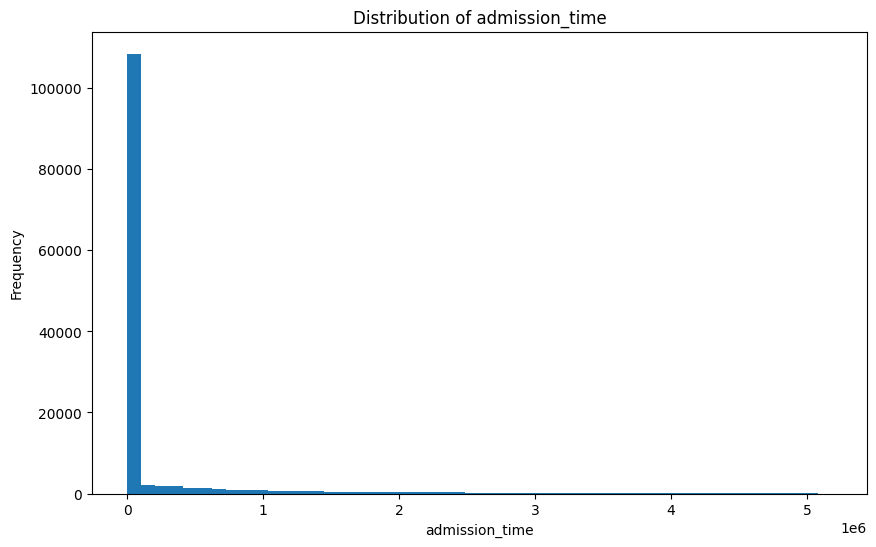

In [39]:
# Basic descriptive statistics for admission_time
print("Descriptive Statistics for admission_time:")
print(df['admission_time'].describe())

# Check for nulls
null_count = df['admission_time'].isnull().sum()
print(f"\nNull values: {null_count}")

# Distribution metrics
print("\nDistribution Info:")
print(f"Skewness: {df['admission_time'].skew():.2f}")
print(f"Kurtosis: {df['admission_time'].kurtosis():.2f}")

# Optional: Quick histogram for visual inspection
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(df['admission_time'].dropna(), bins=50)
plt.title('Distribution of admission_time')
plt.xlabel('admission_time')
plt.ylabel('Frequency')
plt.show()

In [49]:
df[df["admission_time"] > 0]["subject_id"]
df[df["subject_id"] == 102707350]["admission_time"]

70        0
217    4320
Name: admission_time, dtype: int64

In [ ]:
# df_lab[[df_lab["subject_id"] == 102707350]]
df_lab[(df["subject_id"] == 102707350) & (df["item_name"] == "calcium")]

KeyError: False